# Relax Challenge

In [189]:
#import statements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [181]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [182]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix 
from sklearn.metrics import classification_report, precision_recall_curve, auc

In [161]:
users = pd.read_csv('C:/Users/airshu23/Desktop/take_home/relax_challenge/takehome_users.csv', encoding = "ISO-8859-1")

In [162]:
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [163]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

In [164]:
engagement = pd.read_csv('C:/Users/airshu23/Desktop/take_home/relax_challenge/takehome_user_engagement.csv')

## Preprocessing on the user 'engagement' log

In [165]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [166]:
# date time formatting
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'], format='%Y-%m-%d')

# keeping on the date portion
engagement['time_stamp'] = engagement['time_stamp'].dt.date

In [167]:
engagement.drop(['visited'] , axis=1, inplace = True)
engagement = engagement[['user_id', 'time_stamp']]

In [168]:
# group all logins by user_id and time stamp
engagement.sort_values(by=['user_id', 'time_stamp'])

#keeping only one entry for multiple logins in single day by same user
engagement.drop_duplicates(inplace = True)

In [169]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement.set_index('time_stamp',inplace=True)

In [170]:
users_in_engagement = sorted(engagement['user_id'].unique())

## Pre-processing on the 'users' dataset

In [171]:
## helper function to determine whether a user is considered 'adopted'
def rolling (unique_id):
    
    global engagement
    global users_in_engagement
    
    
    if unique_id not in users_in_engagement:       #check to see user_id is in 'engagement' dataframe
        return np.nan
    
    df = engagement.loc[engagement['user_id'].isin([unique_id])]
    
    df['rolling'] = df.rolling('7d', min_periods = 3).count()
    
    if df['rolling'].max() >= 3:
        return 1.0
    
    return 0.0

In [172]:
users['adopted'] = users['object_id'].apply(rolling) 

C:\Users\airshu23\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [173]:
users = users[users['adopted'].notnull()]

In [174]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null object
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
adopted                       8823 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 827.2+ KB


In [178]:
#removing string variables and numerical values with no underlying meaning
users.drop(['object_id', 'creation_time', 'name', 'email', 'org_id', 'invited_by_user_id', 
            'last_session_creation_time'], axis=1, inplace = True) 

data = pd.get_dummies(users, columns=['creation_source'], drop_first = True)

## Model Building

In [179]:
X = data.drop('adopted', axis = 1)
y = data['adopted']

In [183]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

In [184]:
X_const = sm.add_constant(X_train)
logit_model= sm.Logit(y_train, X_const)
result=logit_model.fit()

C:\Users\airshu23\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.469296
         Iterations 6


In [185]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                    Logit                  Pseudo R-squared:       0.004     
Dependent Variable:       adopted                AIC:                    6638.5799 
Date:                     2019-04-16 19:48       BIC:                    6686.6133 
No. Observations:         7058                   Log-Likelihood:         -3312.3   
Df Model:                 6                      LL-Null:                -3326.4   
Df Residuals:             7051                   LLR p-value:            8.3359e-05
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           6.0000                                                   
-----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
const                              -1.2942   0.0704 -18.3827 0.0000 -1.4322 -1.1562
opted_in_to_mailing_list            0.0045   0.0816   0.0553 0.9559 -0.1554  0.1644
enabled_for_marketing_drip          0.1066   0.0970   1.0993 0.2716 -0.0834  0.2966
creation_source_ORG_INVITE         -0.2792   0.0858  -3.2556 0.0011 -0.4473 -0.1111
creation_source_PERSONAL_PROJECTS  -0.0381   0.1202  -0.3166 0.7516 -0.2737  0.1976
creation_source_SIGNUP             -0.4612   0.0988  -4.6693 0.0000 -0.6548 -0.2676
creation_source_SIGNUP_GOOGLE_AUTH -0.2860   0.1045  -2.7371 0.0062 -0.4908 -0.0812
===================================================================================

"""

The data provided is not very useful in predicting which users will be 'adopted'. See ROC curve below. Also none of the variables are significant at the 5% significance level except 'Org Invite'.  More demographic information on the users may be fruitful.

## Model Performance

In [186]:
X_test_plus_const = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test_plus_const)

#predicction on test set converted to 1's and 0's
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

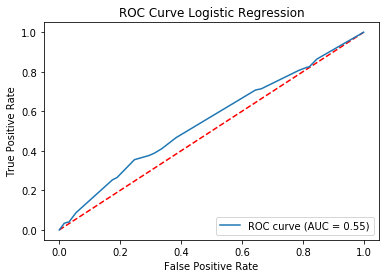

In [187]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

auc = roc_auc_score(y_test, y_pred_prob)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc='lower right')
plt.show()

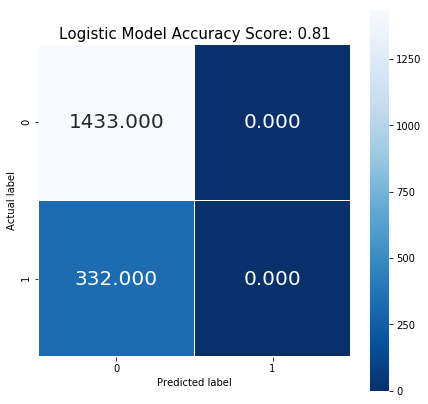

In [190]:
# Compute and visualize confusion matrix 
cm = confusion_matrix(y_test, y_pred_binary)

score = accuracy_score(y_test, y_pred_binary)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True,  annot_kws={"size": 20}, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Model Accuracy Score: {:.2f}'.format(score)

plt.title(all_sample_title, size = 15)
plt.show()

In [191]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90      1433
         1.0       0.00      0.00      0.00       332

   micro avg       0.81      0.81      0.81      1765
   macro avg       0.41      0.50      0.45      1765
weighted avg       0.66      0.81      0.73      1765



C:\Users\airshu23\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\airshu23\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\airshu23\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
